# 3. Modeling
## 3.3 Neural Networks

After modeling with logistic regression, this notebook will focus on the neural network. We will use neural network modeling to establish a classification system that will predict the likelihood of adoption for intake animals. This system will help shelters to make necessary adjustments for these animals and to continuously improve adoption rates.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

---
### Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
austin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/animal_shelter/austin-combined-shelter-data.csv')
austin.head()

,animal_id,outcome_time,date_of_birth,outcome_type,outcome_gender,outcome_age,intake_time,found_location,intake_type,intake_condition,animal_type,intake_gender,intake_age,breed,color,stay_duration,spay_neuter
0,A912799,2024-10-17 13:07:00,2024-07-21,Adoption,Spayed Female,2.0,2024-09-05 14:57:00,7201 Levander Loop in Austin (TX),Abandoned,Normal,Cat,Intact Female,1.0,Domestic Shorthair,Brown Tabby,41,1
1,A912055,2024-10-17 12:25:00,2023-10-25,Adoption,Neutered Male,11.0,2024-08-25 08:20:00,1800 Fairlawn Lane in Austin (TX),Stray,Injured,Cat,Intact Male,10.0,Domestic Shorthair,Brown Tabby/White,53,1
2,A915002,2024-10-17 12:21:00,2023-10-10,Return to Owner,Intact Male,12.0,2024-10-10 12:10:00,Austin (TX),Public Assist,Normal,Dog,Intact Male,12.0,German Shepherd Mix,Tan,7,0
3,A832172,2024-10-17 12:20:00,2021-01-24,Return to Owner,Neutered Male,36.0,2024-10-10 12:10:00,Austin (TX),Public Assist,Normal,Dog,Neutered Male,36.0,Pit Bull Mix,Brown/White,7,0
4,A912548,2024-10-17 11:45:00,2021-09-02,Adoption,Neutered Male,36.0,2024-09-02 22:31:00,6900 Bryn Mawr in Austin (TX),Stray,Normal,Dog,Intact Male,36.0,Siberian Husky Mix,Black/White,44,1


In [ ]:
dallas = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/animal_shelter/dallas-combined-shelter-data.csv')
dallas.rename(columns={'animal_breed': 'breed'}, inplace=True)
dallas.head()

,animal_id,animal_type,breed,intake_type,reason,intake_date,intake_condition,outcome_type,outcome_date,outcome_condition,stay_duration
0,A1229376,CAT,DOMESTIC SH,DISPOS REQ,OTHRINTAKS,2024-10-04,DECEASED,DISPOSAL,2027-10-04,DECEASED,1095
1,A1229851,DOG,MIXED BREED,STRAY,OTHRINTAKS,2024-10-09,APP WNL,ADOPTION,2024-10-27,APP WNL,18
2,A1225816,CAT,DOMESTIC SH,FOSTER,SURGERY,2024-10-26,APP WNL,ADOPTION,2024-10-27,APP WNL,1
3,A1204135,DOG,MIXED BREED,FOSTER,FOR ADOPT,2024-10-27,APP WNL,ADOPTION,2024-10-27,APP WNL,0
4,A1231147,DOG,CHIHUAHUA SH,OWNER SURRENDER,PERSNLISSU,2024-10-24,APP WNL,ADOPTION,2024-10-27,APP WNL,3


---
### Modeling

#### Austin Shelter

In this part, we will use the comprehensive data on animal intakes and outcomes from Austin shelters. By utilizing the various available features, we will provide a neural network model to help shelters in Austin to predict the likelihood of adoption for intake animals.

In [ ]:
X = austin[['outcome_gender', 'outcome_age', 'intake_type', 'intake_condition', 'animal_type',
        'breed', 'color', 'stay_duration', 'spay_neuter']]
y = austin['outcome_type'].apply(lambda x: 1 if x in ['Adoption', 'Return to Owner'] else 0)

In [ ]:
y.value_counts(normalize=True)

,proportion
outcome_type,
1,0.629693
0,0.370307


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
ctx = ColumnTransformer(
    transformers=[
        ('ss', StandardScaler(), ['outcome_age', 'stay_duration']),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
         ['outcome_gender', 'intake_type', 'intake_condition', 'animal_type', 'breed', 'color', 'spay_neuter'])],
    verbose_feature_names_out=False,
    remainder='passthrough')

In [ ]:
X_train_ctx = ctx.fit_transform(X_train)
X_test_ctx = ctx.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
# https://stackoverflow.com/questions/44716150/how-can-i-assign-a-class-weight-in-keras-in-a-simple-way
# calculate class weight for the imbalanced data
y_train = np.array(y_train).flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 1.3549192137490995, 1: 0.792425291161335}

In [ ]:
model = Sequential()
es = EarlyStopping(patience=5)

# input layer
model.add(Input(shape = X_train_ctx[0].shape))

# hidden layers
model.add(Dense(32, activation=None, kernel_regularizer=l2(0.005)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(32, activation=None, kernel_regularizer=l2(0.005)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(64, activation=None, kernel_regularizer=l2(0.005)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

res = model.fit(X_train_ctx, y_train,
                validation_data=(X_test_ctx, y_test),
                epochs=20,
                batch_size=32,
                callbacks=[es],
                class_weight=class_weight_dict)

Epoch 1/20
3292/3292 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7810 - loss: 0.6907 - val_accuracy: 0.8302 - val_loss: 0.4482
Epoch 2/20
3292/3292 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8263 - loss: 0.4680 - val_accuracy: 0.8267 - val_loss: 0.4484
Epoch 3/20
3292/3292 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8243 - loss: 0.4670 - val_accuracy: 0.8358 - val_loss: 0.4408
Epoch 4/20
3292/3292 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8275 - loss: 0.4577 - val_accuracy: 0.8351 - val_loss: 0.4416
Epoch 5/20
3292/3292 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8278 - loss: 0.4583 - val_accuracy: 0.8272 - val_loss: 0.4328
Epoch 6/20
3292/3292 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8277 - loss: 0.4569 - val_accuracy: 0.8286 - val_loss: 0.4355
Epoch 7/20
3292/3292 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8293 - loss: 0.4570 - val_accuracy: 0.8339 - val_loss: 0.4356
Epoch 8/20
3292/3292 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8303 - loss: 0

In [ ]:
pred = model.predict(X_test_ctx)

1098/1098 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
model.evaluate(X_test_ctx, y_test)

1098/1098 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8193 - loss: 0.4600


[0.45762404799461365, 0.820188581943512]

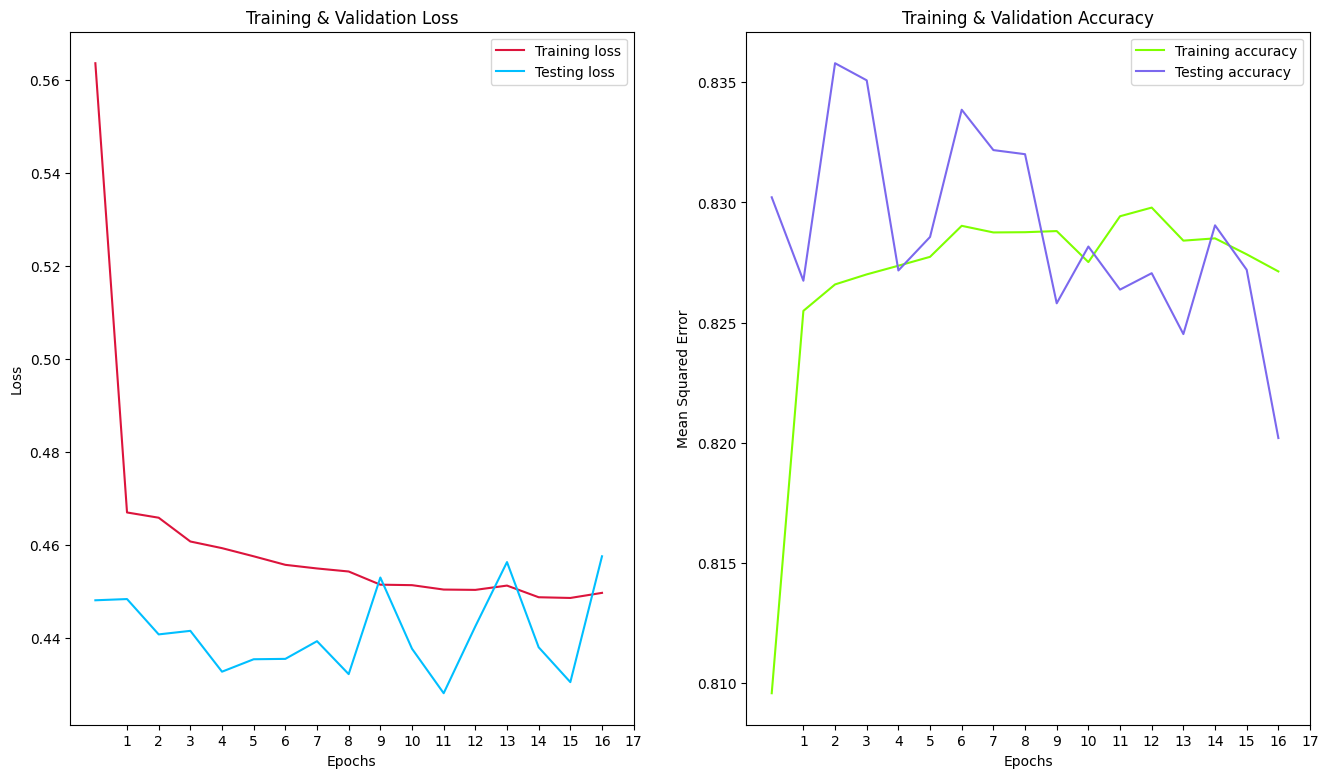

In [ ]:
plt.figure(figsize=(16, 9))
# loss
plt.subplot(1, 2, 1)
plt.plot(res.history['loss'], label='Training loss', color='crimson')
plt.plot(res.history['val_loss'], label='Testing loss', color='deepskyblue')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.xticks(range(1, len(res.history['loss']) + 1))
plt.ylabel('Loss')
plt.legend()

# acc
plt.subplot(1, 2, 2)
plt.plot(res.history['accuracy'], label='Training accuracy', color='chartreuse')
plt.plot(res.history['val_accuracy'], label='Testing accuracy', color='mediumslateblue')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(range(1, len(res.history['loss']) + 1))
plt.ylabel('Mean Squared Error')
plt.legend();

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, pred.round()).ravel()

In [ ]:
metrics = {
    'Accuracy': res.history['val_accuracy'][-1],
    'Sensitivity': recall_score(y_test, pred.round()),
    'Precision': precision_score(y_test, pred.round()),
    'Specificity': tn / (tn + fp),
    'ROC AUC': roc_auc_score(y_test, pred),
    'F1': f1_score(y_test, pred.round()),
}
metrics = pd.DataFrame([metrics], index=['Austin'])
metrics

,Accuracy,Sensitivity,Precision,Specificity,ROC AUC,F1
Austin,0.820189,0.878806,0.841028,0.722138,0.880953,0.859502


The model outcomes shows decent performance according the metrics above.
* Accuracy: The overall correct prediction proportion is 82%.
* Precision: When the model predicts a positive class, it's correct about 84.1% of the time. High precision means fewer false positives.
* Specificity: This reflects the model's ability to correctly identify negatives. A specificity of 72.21% suggests that there are a fair number of false negatives. The model still needs improvement because every false negative represents an animal with a high adoption likelihood that is mistakenly classified as not likely to be adopted.
* ROC AUC: AUC indicates the model's ability to distinguish between classes. A value of 88% suggestes a decent model performance.
* The validation accuracy fluctuated around 82-83% after using batch normalization, l2 regularization and dropout to combat overfitting, which indicates the model still have space for future improvement(such as hyperparameters tuning).

---
#### Dallas Shelters

The intake and outcome records of Dallas shelters come with less information compared to the Austin shelter, which is a challenge for our model due to the limited available features.

In [ ]:
X = dallas[['animal_type', 'breed', 'intake_type', 'reason', 'outcome_condition', 'stay_duration']]
y = dallas['outcome_type'].apply(lambda x: 1 if x in ['ADOPTION', 'RETURNED TO OWNER'] else 0)

In [ ]:
y.value_counts(normalize=True)

,proportion
outcome_type,
0,0.554237
1,0.445763


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
ctx = ColumnTransformer(
    transformers=[
        ('ss', StandardScaler(), ['stay_duration']),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
         ['animal_type', 'breed', 'intake_type', 'reason', 'outcome_condition'])],
    verbose_feature_names_out=False,
    remainder='passthrough')

In [ ]:
X_train_ctx = ctx.fit_transform(X_train)
X_test_ctx = ctx.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# not using the class weight since the data is roughly balanced
# y_train = np.array(y_train).flatten()
# class_weights2 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weight_dict2 = {i: class_weights2[i] for i in range(len(class_weights2))}
# class_weight_dict2

In [ ]:
model2 = Sequential()
es = EarlyStopping(patience=5)

# input layer
model2.add(Input(shape = X_train_ctx[0].shape))

# hidden layers
model2.add(Dense(32, activation=None, kernel_regularizer=l2(0.01)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

model2.add(Dense(32, activation=None, kernel_regularizer=l2(0.005)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.4))

model2.add(Dense(64, activation=None, kernel_regularizer=l2(0.001)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.4))

# output layer
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

res2 = model2.fit(X_train_ctx, y_train,
                validation_data=(X_test_ctx, y_test),
                epochs=50,
                batch_size=32,
                callbacks=[es],
                #class_weight=class_weight_dict2
)

Epoch 1/50
5994/5994 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7575 - loss: 0.6179 - val_accuracy: 0.7991 - val_loss: 0.4301
Epoch 2/50
5994/5994 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.7900 - loss: 0.4524 - val_accuracy: 0.8002 - val_loss: 0.4281
Epoch 3/50
5994/5994 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.7896 - loss: 0.4486 - val_accuracy: 0.7966 - val_loss: 0.4228
Epoch 4/50
5994/5994 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.7887 - loss: 0.4456 - val_accuracy: 0.7975 - val_loss: 0.4314
Epoch 5/50
5994/5994 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.7915 - loss: 0.4409 - val_accuracy: 0.7991 - val_loss: 0.4261
Epoch 6/50
5994/5994 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.7922 - loss: 0.4416 - val_accuracy: 0.7985 - val_loss: 0.4218
Epoch 7/50
5994/5994 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.7893 - loss: 0.4410 - val_accuracy: 0.7954 - val_loss: 0.4289
Epoch 8/50
5994/5994 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.7884 - loss: 0

In [ ]:
pred2 = model2.predict(X_test_ctx)

1998/1998 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [ ]:
model2.evaluate(X_test_ctx, y_test)

1998/1998 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7970 - loss: 0.4253


[0.425864577293396, 0.797722578048706]

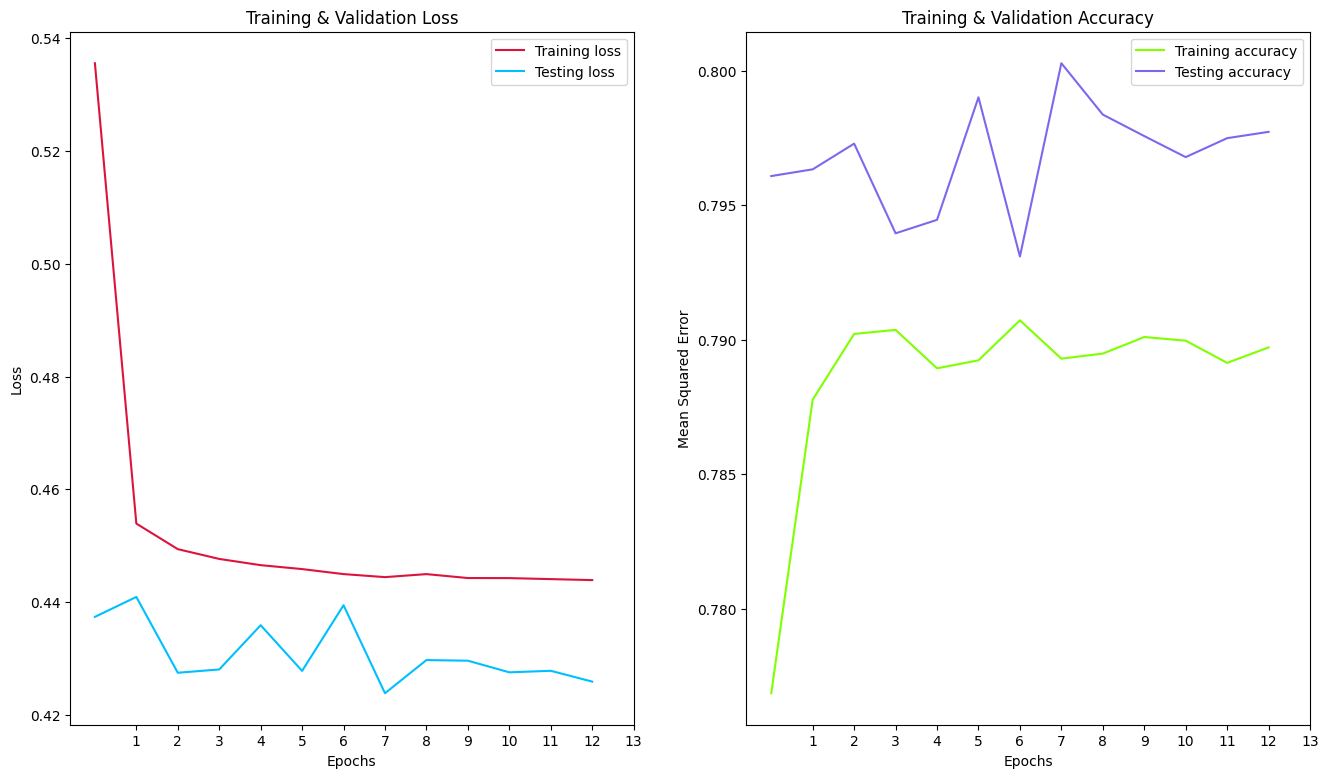

In [ ]:
plt.figure(figsize=(16, 9))
# loss
plt.subplot(1, 2, 1)
plt.plot(res2.history['loss'], label='Training loss', color='crimson')
plt.plot(res2.history['val_loss'], label='Testing loss', color='deepskyblue')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.xticks(range(1, len(res2.history['loss']) + 1))
plt.ylabel('Loss')
plt.legend()

# acc
plt.subplot(1, 2, 2)
plt.plot(res2.history['accuracy'], label='Training accuracy', color='chartreuse')
plt.plot(res2.history['val_accuracy'], label='Testing accuracy', color='mediumslateblue')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(range(1, len(res2.history['loss']) + 1))
plt.ylabel('Mean Squared Error')
plt.legend();

In [ ]:
report2 = classification_report(y_test, pred2.round())
print(report2)

              precision    recall  f1-score   support

           0       0.92      0.70      0.79     35657
           1       0.71      0.93      0.80     28275

    accuracy                           0.80     63932
   macro avg       0.81      0.81      0.80     63932
weighted avg       0.83      0.80      0.80     63932



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, pred2.round()).ravel()

In [ ]:
metrics2 = {
    'Accuracy': res2.history['val_accuracy'][-1],
    'Sensitivity': recall_score(y_test, pred2.round()),
    'Precision': precision_score(y_test, pred2.round()),
    'Specificity': tn / (tn + fp),
    'ROC AUC': roc_auc_score(y_test, pred2),
    'F1': f1_score(y_test, pred2.round()),
}
metrics2 = pd.DataFrame([metrics2], index=['Dallas'])
metrics2

,Accuracy,Sensitivity,Precision,Specificity,ROC AUC,F1
Dallas,0.797723,0.926472,0.707064,0.695628,0.89157,0.802033


* Overall, the model for Dallas is not as strong as the Austin model. However, it does show promising results in sensitivity, which is 93%, indicating that it is effective at identifying animals likely to be adopted.<br>
* Specificity also reflects the model's ability to correctly identify negatives. Similar to the Austin model, the specificity suggests that there are a fair number of false negatives. This model still needs improvements.

In [ ]:
result = pd.concat([metrics, metrics2])
result = round(result, 2)
result

,Accuracy,Sensitivity,Precision,Specificity,ROC AUC,F1
Austin,0.82,0.88,0.84,0.72,0.88,0.86
Dallas,0.80,0.93,0.71,0.70,0.89,0.80


In [ ]:
nn_result = result.drop(columns=['Sensitivity', 'ROC AUC', 'F1'])

# Conclusion and Recommendations
___

### <center>Logistic Regression Prediction Performance</center>

||Accuracy|Precision|Specificity|
|---|---|---|---|
|**Austin**|0.83|0.84|0.67|
|**Dallas**|0.74|0.70|0.75|

### <center>Neural Net Prediction Performance</center>

||Accuracy|Precision|Specificity|
|---|---|---|---|
|**Austin**|0.82|0.84|0.72|
|**Dallas**|0.80|0.71|0.70|

<br>
With our main focus being specificity in order to catch as many pets in need of assistance as possible, for the data collected by Austin shelters the final Logistic Regression through Stacking Classifier is the one to move forward with. For the data collected by Dallas shelters the final Neural Network is the final model.

## Future improvements

There are some recommendations for shelters in order to improve these models and better predict their animals' outcomes
* If shelter's can provide more detail for each animal, we can utilize more features suited for prediction
* Also if shelters provide an image we could also include image classification functionality to recognize breed and animal types.

For further project goals, it would be beneficial to find other cities that provide data regarding their shelter intakes and outcomes to provide a network of models where we can predict where an animal's best chances for adoption are.